In [1]:
try:
  import mat73
except:
  !pip install -q mat73
  import mat73

try:
  import hdf5storage
except:
  !pip install hdf5storage

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.5/75.5 kB 3.2 MB/s eta 0:00:00


In [2]:
import os
import numpy as np
import numba as nb
from sklearn.utils.extmath import randomized_svd
import matplotlib.pyplot as plt
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import hdf5storage
import gdown
import warnings
import time
timestr = time.strftime("%Y-%m-%d_%H.%M.%S")

# DEFINE NECESSARY FUNCTIONS FOR PERFORMING HODMD

In [3]:
def dmd1(V,t,esvd,edmd):
    '''First order dynamic modal decomposition:
        Input:
            -V (IxJ): Snapshot matrix.
            -t (J): Time vector.
            -esvd: First tolerance (SVD).
            -edmd: Second tolerance (DMD modes).
        Output:
            -u (Ixn): mode matrix (columns) sorted from biggest to smallest amplitude, put to scale.
            -areal (n): amplitude vector (sorted) used to put u to scale.
            -eigval: eigenvalues
            -delta (n): growth rate vector.
            -omega (n): frequency vector.
            -DMDmode: Modes'''
    dt=t[1]-t[0]

    # Reduced snapshots:
    U,s,Wh=truncatedSVD(V,esvd)
    Vvir=np.diag(s)@Wh
    n=s.size

    # Spatial complexity kk:
    NormS=np.linalg.norm(s,ord=2)
    kk=0
    for k in range(0,n):
        if np.linalg.norm(s[k:n],2)/NormS>esvd:
            kk=kk+1
    print(f'Spatial complexity: {kk}')

    # Koopman matrix reconstruction:
    Uvir,svir,Wvirh=np.linalg.svd(Vvir[:,:-1],full_matrices=False) #r'*r', r'*r', r'*(J-1)
    Rvir=Vvir[:,1:]@Wvirh.conj().T@np.diag(svir**-1)@Uvir.conj().T #r'*r'
    eigval,eigvec=np.linalg.eig(Rvir) #r'*r'

    # Frequencies and Growthrate:
    delta=np.log(eigval).real/dt #r'
    omega=np.log(eigval).imag/dt #r'

    # Amplitudes:
    A=np.zeros((eigvec.shape[0]*Vvir.shape[1],eigvec.shape[1]))
    b=np.zeros(eigvec.shape[0]*Vvir.shape[1])
    for i in range(Vvir.shape[1]):
        A[i*eigvec.shape[0]:(i+1)*eigvec.shape[0],:]=eigvec@np.diag(eigval**i)
        b[i*eigvec.shape[0]:(i+1)*eigvec.shape[0]]=Vvir[:,i]

    Ua,sa,Wa=np.linalg.svd(A,full_matrices=False)
    a=Wa.conj().T@np.diag(sa**-1)@Ua.conj().T@b

    # Modes:
    uvir=eigvec@np.diag(a)
    u=U@uvir

    areal=np.linalg.norm(u,axis=0)/np.sqrt(V.shape[0])

    #Spectral complexity:
    kk3=0
    for m in range(0,np.size(areal)):
        if areal[m]/np.max(areal)>edmd:
            kk3=kk3+1
    print(f'Spectral complexity: {kk3}')

    idx=np.flip(np.argsort(areal))
    u=u[:,idx]
    areal=areal[idx]
    eigval=eigval[idx]
    delta=delta[idx]
    omega=omega[idx]

    # Filter important ones:
    mask=(areal/areal[0])>edmd

    # Mode Matrix:
    ModeMatr=np.zeros((kk3,4))
    for ii in range(0,kk3):
        ModeMatr[ii,0]=ii+1
        ModeMatr[ii,1]=delta[mask][ii]
        ModeMatr[ii,2]=omega[mask][ii]
        ModeMatr[ii,3]=areal[mask][ii]

    # Calculate modes:
    u=u[:,mask]
    U = U[:,0:kk]
    DMDmode=np.zeros((V.shape[0],kk3),dtype=np.complex128)
    Amplitude0=np.zeros(kk3)
    for m in range(0,kk3):
        NormMode=np.linalg.norm(np.dot(U,u[:,m]),ord=2)/np.sqrt(V.shape[0])
        Amplitude0[m]=NormMode
        DMDmode[:,m]=np.dot(U,u[:,m])/NormMode

    return u,areal[mask],eigval[mask],delta[mask],omega[mask],DMDmode

In [4]:
def hodmd(V,d,t,esvd,edmd):
    '''High order (d) modal decomposition:
        Input:
            -V (IxJ): snapshot matrix.
            -t (J): time vector.
            -d: parameter of DMD-d, higher order Koopman assumption (int>=1).
            -esvd: first tolerance (SVD).
            -edmd: second tolerance (DMD-d modes).
        Output:
            -u (Ixn): mode matrix (columns) sorted from biggest to smallest amplitude, put to scale.
            -areal (n): amplitude vector (sorted) used to put u to scale.
            -eigval: eigenvalues
            -delta (n): growth rate vector.
            -omega (n): frequency vector.
            -DMDmode: Modes'''
    dt=t[1]-t[0]

    # Reduced snapshots:
    U,s,Wh=truncatedSVD(V,esvd)
    Vvir=np.diag(s)@Wh
    n=s.size

    # Spatial complexity kk:
    NormS=np.linalg.norm(s,ord=2)
    kk=0
    for k in range(0,n):
        if np.linalg.norm(s[k:n],2)/NormS>esvd:
            kk=kk+1
    print(f'Spatial complexity: {kk}')

    # Reduced and grouped snapshots:
    Vdot=np.zeros((d*n,Vvir.shape[1]-d+1),dtype=Vvir.dtype)
    for j in range(d):
      Vdot[j*n:(j+1)*n,:]=Vvir[:,j:Vvir.shape[1]-d+j+1]

    # Reduced, grouped and again reduced snapshots:
    Udot,sdot,Whdot=truncatedSVD(Vdot,esvd)
    Vvd=np.diag(sdot)@Whdot

    # Spatial dimension reduction:
    print(f'Spatial dimension reduction: {np.size(sdot)}')

    # Koopman matrix reconstruction:
    Uvd,svd,Whvd=np.linalg.svd(Vvd[:,:-1],full_matrices=False)
    Rvd=Vvd[:,1:]@Whvd.conj().T@np.diag(svd**-1)@Uvd.conj().T
    eigval,eigvec=np.linalg.eig(Rvd)

    # Frequencies and growthrate:
    delta=np.log(eigval).real/dt
    omega=np.log(eigval).imag/dt

    # Modes
    q=(Udot@eigvec)[(d-1)*n:d*n,:]
    Uvir=q/np.linalg.norm(q,axis=0)

    # Amplitudes:
    A=np.zeros((Uvir.shape[0]*Vvir.shape[1],Uvir.shape[1]),dtype=np.complex128) #(n*J)*N

    b=np.zeros(Uvir.shape[0]*Vvir.shape[1],dtype=Vvir.dtype)#(n*J)*1
    for i in range(Vvir.shape[1]):
        A[i*Uvir.shape[0]:(i+1)*Uvir.shape[0],:]=Uvir@np.diag(eigval**i)
        b[i*Uvir.shape[0]:(i+1)*Uvir.shape[0]]=Vvir[:,i]

    Ua,sa,Wa=np.linalg.svd(A,full_matrices=False) #(n*J)*N, N*N, N*N
    a=Wa.conj().T@np.diag(sa**-1)@Ua.conj().T@b #N

    # Modes
    uvir=Uvir@np.diag(a) #n*N
    u=U@uvir #I*N
    areal=np.linalg.norm(u,axis=0)/np.sqrt(V.shape[0])
    # print("Size ufull: ",u.shape)

    #Spectral complexity:
    kk3=0
    for m in range(0,np.size(areal)):
        if areal[m]/np.max(areal)>edmd:
            kk3=kk3+1
    print(f'Spectral complexity: {kk3}')

    idx=np.flip(np.argsort(areal))
    u=u[:,idx]
    areal=areal[idx]
    eigval=eigval[idx]
    delta=delta[idx]
    omega=omega[idx]

    #Filter important ones:
    mask=(areal/areal[0])>edmd

    #Mode Matrix:
    ModeMatr=np.zeros((kk3,4))
    for ii in range(0,kk3):
        ModeMatr[ii,0]=ii+1
        ModeMatr[ii,1]=delta[mask][ii]
        ModeMatr[ii,2]=omega[mask][ii]
        ModeMatr[ii,3]=areal[mask][ii]

    #Calculate DMD modes:
    u=u[:,mask]
    U = U[:,0:kk]
    DMDmode=np.zeros((V.shape[0],kk3),dtype=np.complex128)
    Amplitude0=np.zeros(kk3)
    for m in range(0,kk3):
        NormMode=np.linalg.norm(np.dot(U.T,u[:,m]),ord=2)/np.sqrt(V.shape[0])
        Amplitude0[m]=NormMode
        DMDmode[:,m]=u[:,m]/NormMode

    return u,areal[mask],eigval[mask],delta[mask],omega[mask],DMDmode

In [5]:
def remake(u,t,mu):
    '''Reconstructs original data from DMD-d results:
        Input:
            -u (Ixn): Mode matrix (columns).
            -t (J): Time vector.
            -delta (n): vector de ratios de crecimiento.
            -omega (n): vector de frecuencias.
            -mu: np.exp(np.dot((t[1]-t[0]),delta[iii]+np.dot(complex(0,1),omega[iii])))
        Output:
            -vrec (IxJ): reconstructed snapshots'''

    vrec=np.zeros((u.shape[0],t.size),dtype=np.complex128)
    for i in range(t.size):
        for j in range(mu.shape[0]):
            vrec[:,i]+=u[:,j]*mu[j]**i
    return vrec

def matlen(var):
    '''Equivalent to Matlab's length()'''
    if np.size(np.shape(var))==1:
        x = np.size(var)
    else:
        x = max(np.shape(var))
    return x

def error(V,Vrec):
    '''Relative RMS and max errors'''
    return np.linalg.norm(V-Vrec)/np.linalg.norm(V),np.linalg.norm(V-Vrec,np.inf)/np.linalg.norm(V,np.inf)

def truncatedSVD(A,esvd):
    '''Decomposition into singular values, truncated on esvd'''
    U,s,Wh=np.linalg.svd(A,full_matrices=False)
    n=0
    norm=np.linalg.norm(s)
    for i in range(s.size):
        if np.linalg.norm(s[i:])/norm<=esvd:
            break
        else:
            n+=1
    return U[:,:n],s[:n],Wh[:n,:]

# LOAD AND PROCESS DATA

In [6]:
gdown.download_folder("https://drive.google.com/drive/folders/1eaL945MC46rwhsft72LE_GtSCl15ugB4", output="./")

print('\nLoading the dataset...')
f = mat73.loadmat('./Test Case/Tensor.mat')
Tensor = f['Tensor']
print('\nDataset loaded!')

# It is necessary to have the temporal dimension last!!
TimePos = Tensor.ndim

SNAP = int(Tensor.shape[-1])  # Change SNAP to reduce number of snapshots
Tensor = Tensor[..., 0:SNAP]

dims = Tensor.ndim
shape = Tensor.shape

Tensor0 = Tensor

Retrieving folder contents


Processing file 1CA9q-RAff409xVOGD2DZtsYLf95BfyGM Tensor.mat
Processing file 1socnlP5vBRpNz9vrUkgUv-54_5RmiAvz X.mat
Processing file 1o1dcqmoDEV6UqtwfdS3i3FafLXX3X5Zb Y.mat


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=1CA9q-RAff409xVOGD2DZtsYLf95BfyGM
From (redirected): https://drive.google.com/uc?id=1CA9q-RAff409xVOGD2DZtsYLf95BfyGM&confirm=t&uuid=a858f41d-7f94-4101-b579-35f28e0b88aa
To: /content/Test Case/Tensor.mat
100%|██████████| 99.3M/99.3M [00:01<00:00, 88.2MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1socnlP5vBRpNz9vrUkgUv-54_5RmiAvz
From (redirected): https://drive.google.com/uc?id=1socnlP5vBRpNz9vrUkgUv-54_5RmiAvz&confirm=t&uuid=032ef13e-7db4-47d7-b38c-3403fea17501
To: /content/Test Case/X.mat
100%|██████████| 8.23k/8.23k [00:00<00:00, 11.5MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1o1dcqmoDEV6UqtwfdS3i3FafLXX3X5Zb
From (redirected): https://drive.google.com/uc?id=1o1dcqmoDEV6UqtwfdS3i3FafLXX3X5Zb&confirm=t&uuid=0d9f8133-aeb3-47cb-9ceb-a78ce56a5366
To: /content/Test Case/Y.ma


Loading the dataset...

Dataset loaded!


In [7]:
print(shape)

(2, 151, 216, 200)


# HODMD MAIN

In [8]:
# CALIBRATION

d = 25              # Number of HODMD windows
varepsilon1 = 1e-2  # Tolerance to truncate the number of SVD modes retained
varepsilon  = 1e-2  # Tolerance to truncate the number of DMD modes retained
deltaT = 1          # Time step of the database

print('\n-----------------------------')
print('HODMD summary:')
print('\n' + f'Number of snapshots set at: {shape[-1]}')
print(f'd Parameter set at: {d}')
print(f'Tolerances set at {varepsilon1} for SVD and {varepsilon} for HODMD')
print(f'Time gradient set at deltaT: {deltaT}')
print('\n-----------------------------')


-----------------------------
HODMD summary:

Number of snapshots set at: 200
d Parameter set at: 25
Tolerances set at 0.01 for SVD and 0.01 for HODMD
Time gradient set at deltaT: 1

-----------------------------


In [9]:
# PERFORM HODMD

Time = np.linspace(0,shape[-1]-1,num=shape[-1])*deltaT

if dims > 2:
	dims_prod = np.prod(shape[:-1])
	Tensor = np.reshape(Tensor, (dims_prod, shape[-1]))

if d==1:
	print('Performing DMD. Please wait...\n')
	[u,Amplitude,Eigval,GrowthRate,Frequency,DMDmode] = dmd1(Tensor, Time, varepsilon1, varepsilon)
	print('\nDMD complete!')
	dt=Time[1]-Time[0]
	icomp=complex(0,1)
	mu=np.zeros(np.size(GrowthRate),dtype=np.complex128)
	for iii in range(0,np.size(GrowthRate)):
		mu[iii] = np.exp(np.dot(dt,GrowthRate[iii]+np.dot(icomp,Frequency[iii])))
	Reconst=remake(u,Time,mu)
else:
	print('Performing HODMD. Please wait...\n')
	[u,Amplitude,Eigval,GrowthRate,Frequency,DMDmode] = hodmd(Tensor, d, Time, varepsilon1, varepsilon)
	print('\nHODMD complete!')
	dt=Time[1]-Time[0]
	icomp=complex(0,1)
	mu=np.zeros(np.size(GrowthRate),dtype=np.complex128)
	for iii in range(0,np.size(GrowthRate)):
		mu[iii] = np.exp(np.dot(dt,GrowthRate[iii]+np.dot(icomp,Frequency[iii])))
	Reconst=remake(u,Time,mu)

DMDmode = np.reshape(DMDmode, shape[:-1] + (len(Frequency),))
GrowthrateFrequencyAmplitude = np.array([GrowthRate, Frequency, Amplitude])
TT = np.real(np.reshape(Reconst, shape))

RRMSE = np.linalg.norm(np.reshape(Tensor-Reconst,newshape=(np.size(Tensor),1)),ord=2)/np.linalg.norm(np.reshape(Tensor,newshape=(np.size(Tensor),1)))
print(f'Relative mean square error made in the calculations: {np.round(RRMSE*100, 3)}%\n')

Performing HODMD. Please wait...

Spatial complexity: 5
Spatial dimension reduction: 5
Spectral complexity: 5

HODMD complete!
Relative mean square error made in the calculations: 0.51%



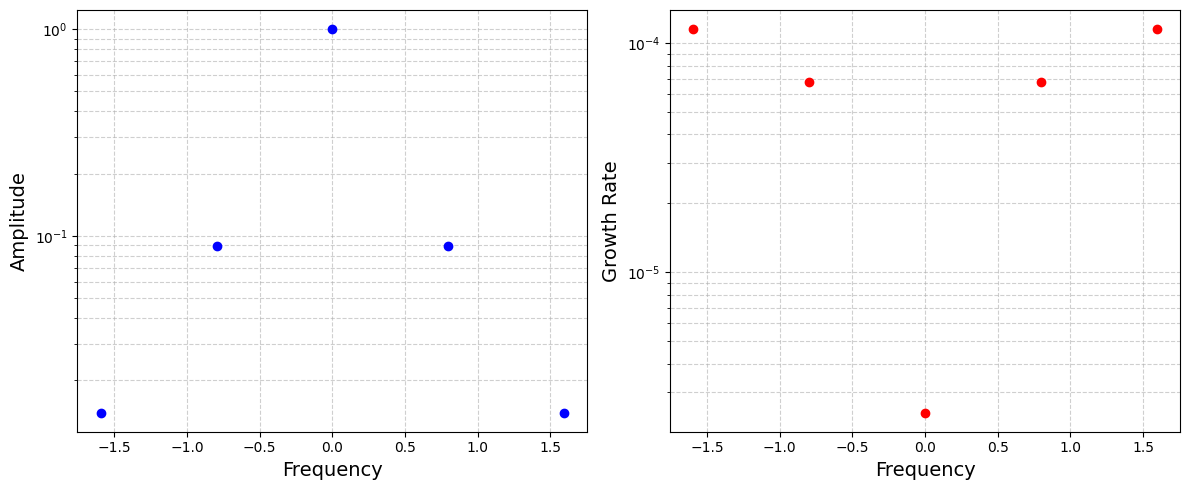

In [10]:
# Plot Amplitude vs Frequency
fig_spec, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(Frequency, Amplitude / np.max(Amplitude), marker='o', color='b', linestyle='', markersize=6)
axes[0].set_yscale("log")
axes[0].set_xlabel("Frequency", fontsize=14)
axes[0].set_ylabel("Amplitude", fontsize=14)
axes[0].grid(True, which="both", linestyle="--", alpha=0.6)
axes[0].spines["top"].set_visible(True)
axes[0].spines["right"].set_visible(True)

# Plot Growth Rate vs Frequency
axes[1].plot(Frequency, np.abs(GrowthRate), marker='o', color='r', linestyle='', markersize=6)
axes[1].set_yscale("log")
axes[1].set_xlabel("Frequency", fontsize=14)
axes[1].set_ylabel("Growth Rate", fontsize=14)
axes[1].grid(True, which="both", linestyle="--", alpha=0.6)
axes[1].spines["top"].set_visible(True)
axes[1].spines["right"].set_visible(True)

plt.tight_layout()
plt.show()

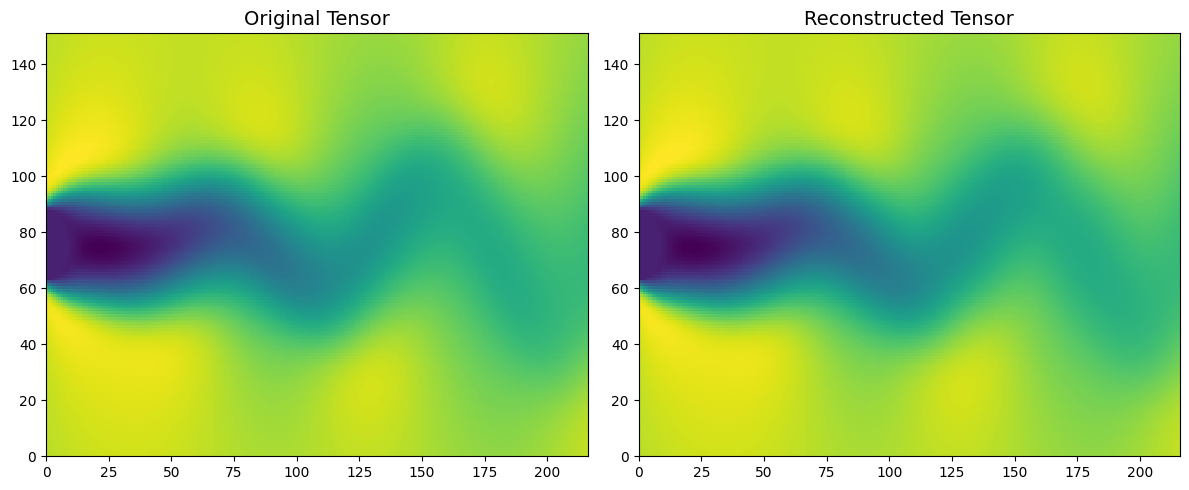

In [11]:
# Plot Original vs Reconstruction

component = 0  # First component

if TimePos == 4:
  original_slice = Tensor0[component, :, :, shape[-1]-1]
  reconstructed_slice = TT[component, :, :, shape[-1]-1]
elif TimePos == 5:
  original_slice = Tensor0[component, :, :, int(shape[3]/2), shape[-1]-1]
  reconstructed_slice = TT[component, :, :, int(shape[3]/2), shape[-1]-1]

vmin, vmax = min(original_slice.min(), reconstructed_slice.min()), max(original_slice.max(), reconstructed_slice.max())

fig_rec, axes_rec = plt.subplots(1, 2, figsize=(12, 5))

# Plot original tensor
im1 = axes_rec[0].pcolor(original_slice, cmap="viridis", shading="auto", vmin=vmin, vmax=vmax)
axes_rec[0].set_title("Original Tensor", fontsize=14)

# Plot reconstructed tensor
im2 = axes_rec[1].pcolor(reconstructed_slice, cmap="viridis", shading="auto", vmin=vmin, vmax=vmax)
axes_rec[1].set_title("Reconstructed Tensor", fontsize=14)

plt.tight_layout()
plt.show()

Real part


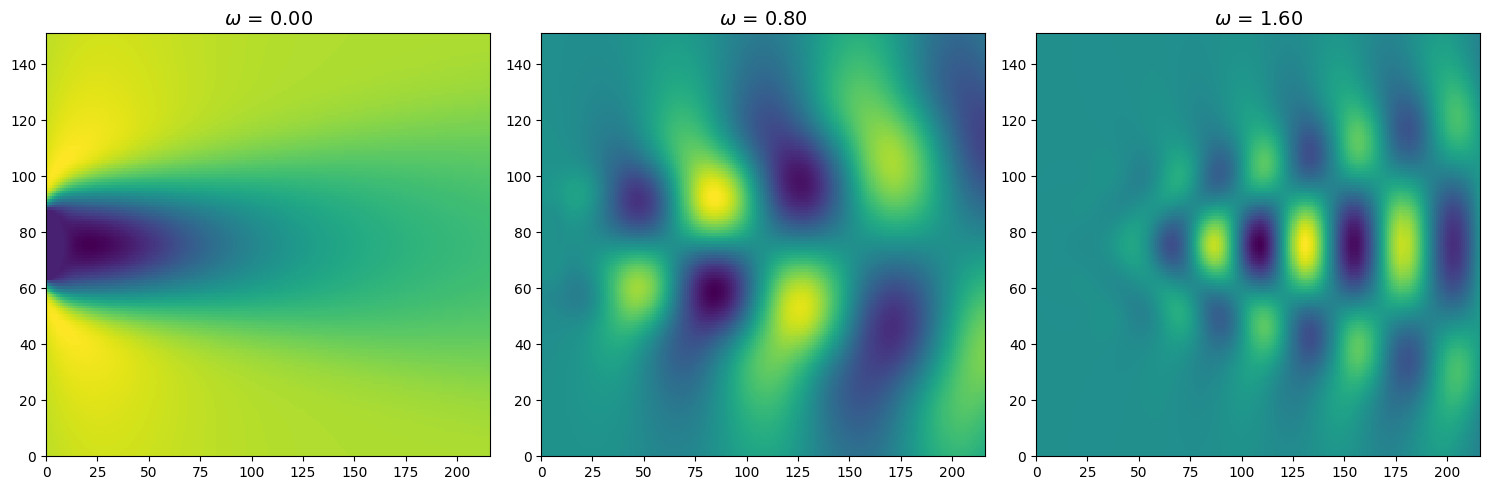

Imaginary part


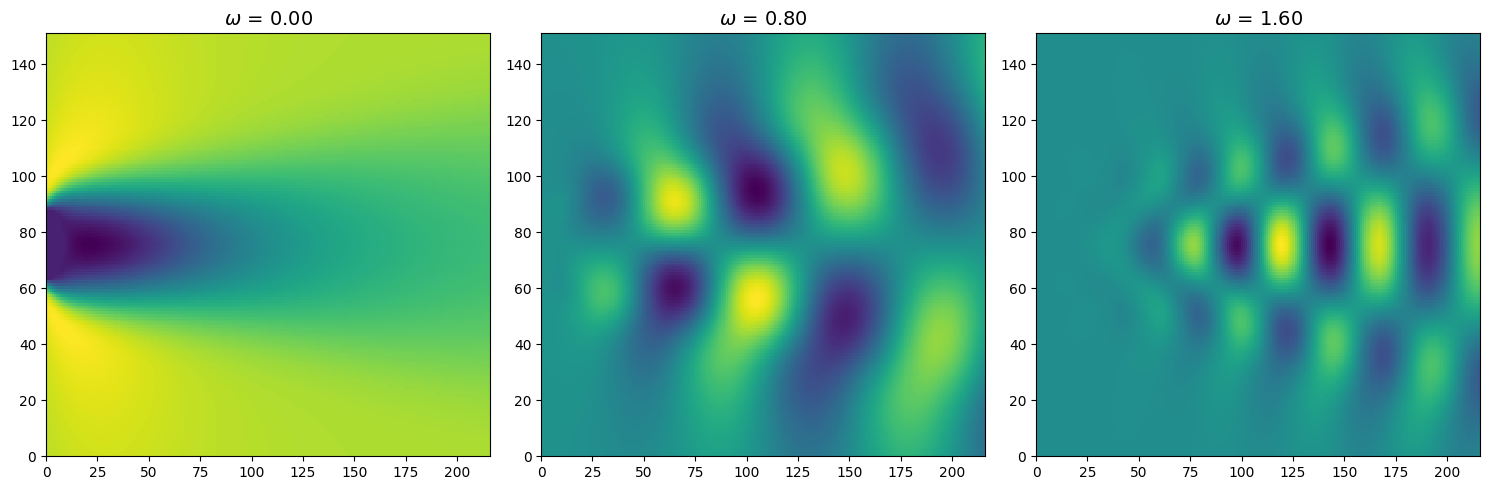

In [12]:
# Plot DMD Modes

# Define component to visualize
component = 0

# Find desired frequencies
freq = np.array([0, 0.8, 1.6])
tolerance = 0.1  # Allowed deviation

indices = [np.argmin(np.abs(Frequency - f)) if np.any(np.abs(Frequency - f) < tolerance) else None for f in freq]

if None in indices:
    warnings.warn("Some frequencies have no match within tolerance. Skipping those modes.")

indices = [idx for idx in indices if idx is not None]

if not indices:
    raise ValueError("No frequencies matched within tolerance. Check your input data.")


# Real part of DMD mode
print('Real part')
if TimePos == 4:
  modes = [np.real(DMDmode[component,:, :, idx]) for idx in indices]
elif TimePos == 5:
  modes = [np.real(DMDmode[component,:, :, int(shape[3]/2), idx]) for idx in indices]

fig_modes, axes_modes = plt.subplots(1, len(freq), figsize=(15, 5))

for i, (ax, mode, f) in enumerate(zip(axes_modes, modes, freq)):

    vmin = min(mode.min() for mode in modes[i])
    vmax = max(mode.max() for mode in modes[i])

    im = ax.pcolor(mode, cmap="viridis", shading="auto", vmin=vmin, vmax=vmax)
    ax.set_title(f"$\omega$ = {f:.2f}", fontsize=14)

plt.tight_layout()
plt.show()

# Imaginary part of DMD mode
print('Imaginary part')
if TimePos == 4:
  modes = [np.imag(DMDmode[component,:, :, idx]) for idx in indices]
elif TimePos == 5:
  modes = [np.imag(DMDmode[component,:, :, int(shape[3]/2), idx]) for idx in indices]

fig_modes, axes_modes = plt.subplots(1, len(freq), figsize=(15, 5))

for i, (ax, mode, f) in enumerate(zip(axes_modes, modes, freq)):

    vmin = min(mode.min() for mode in modes[i])
    vmax = max(mode.max() for mode in modes[i])

    im = ax.pcolor(mode, cmap="viridis", shading="auto", vmin=vmin, vmax=vmax)
    ax.set_title(f"$\omega$ = {f:.2f}", fontsize=14)

plt.tight_layout()
plt.show()